<a href="https://colab.research.google.com/github/manneryzach/mcgill-physics-hack2021/blob/main/chnaldi_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The sound of geometry
Chnaldi figures are obtained when a certain piece of material, usually circular of square, is vibrating in a particular mode. The nodes and anti-nodes 
formed by the oscillation make complex but symmetrical patterns all over the surface that can be seen if a fine grain material is sprinkled on top of the surface.

These calculations can also be applied to the case of a vibrating membrane, or drum. Changing the shape of the drum will change it's harmonics and hence it's sound. Our project explores how different shaped drums produce different harmonics and different sounds when struck.

To get those fancy patterns, our code is solving the Helmholtz equation with Dirichlet boundary conditions: 


\begin{cases} \nabla^2 u(\vec{r}) + \lambda^2 u(\vec{r})=0 \quad on \  \Omega\ \\ u(\vec{r})=0 \quad on \ \partial \Omega \end{cases}




Which is derived by separation of variables on the wave equation: 

\begin{align}
\nabla^2 \psi(t,\vec{r})=\frac{1}{v^2}\frac{\partial^2 \psi(t,\vec{r})}{\partial^2 t} \\ 
\psi(t,\vec{r})=\phi(t)u(\vec{r}) \\
\Rightarrow \ \ \nabla^2 \phi u = \frac{1}{v^2}\partial^2_t \phi u \\
\frac{1}{u}\nabla^2 u=\frac{1}{v^2}\frac{1}{\phi}\partial_t^2 \phi = -\lambda^2
\end{align}

# Packages & Dependencies


In [52]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
  
!pip3 install pygame

     |████████████████████████████████| 18.3 MB 86 kB/s 


# Imports

In [59]:

from dolfin import *
from mshr import *
import numpy as np
from ufl import inner, grad, dx
import matplotlib.pyplot as plt
import pygame, sys
from pygame.locals import *

# import os
# os.environ['SDL_VIDEODRIVER']='dummy'
# pygame.display.set_mode((640,480))
# from google.colab.patches import cv2_imshow
# from google.colab import output

# Initial conditions


In [63]:
# Point and Line class definitions
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Line:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2

    def getStartPoint(self):
        return (self.p1.x, self.p1.y)

    def getEndPoint(self):
        return (self.p2.x, self.p2.y)

# Verifies if 3 points are colinear
def onLine(p, q, r):
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
        return True
    return False

# Finds orientation of 3 points, clockwise, counterclockwise or collinear
def orientation(p, q, r):
    # to find the orientation of 3 points (p, q, r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise

    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
    if (val > 0):

        # Clockwise orientation
        return 1
    elif (val < 0):

        # Counterclockwise orientation
        return 2
    else:

        # Collinear orientation
        return 0


# The main function that returns true if
# the line segment 'p1q1' and 'p2q2' intersect.
def doIntersect(line1, line2):
    # Find the 4 orientations required for
    # the general and special cases

    p1 = line1.p1
    q1 = line1.p2
    p2 = line2.p1
    q2 = line2.p2

    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True

    # Special Cases

    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and onLine(p1, p2, q1)):
        return True

    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and onLine(p1, q2, q1)):
        return True

    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and onLine(p2, p1, q2)):
        return True

    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and onLine(p2, q1, q2)):
        return True

    # If none of the cases
    return False

# Simple method to draw a straight line after validation
def drawLine(surface, newLine):
    start = newLine.getStartPoint()
    end = newLine.getEndPoint()
    pygame.draw.line(surface, black, start, end)
    pygame.display.update()

# Return true if line does not intersect, false if it does
def validateLine(newLine, lineList):
    intersect = False

    if(len(lineList) == 0):
        return True
    else:
        for line in lineList:
            if (line == lineList[len(lineList) - 1]):
                return True
            intersect = doIntersect(line, newLine)
            if(intersect):
                return False

    return True

# Validation, called only when trying to exit program
def validateLastLine(newLine, lineList):
    if (len(lineList) == 0):
        return True
    else:
        tempList = [line for line in lineList]
        del tempList[0]
        for line in tempList:
            if (line == tempList[len(tempList) - 1]):
                return True
            intersect = doIntersect(line, newLine)
            if (intersect):
                return False

    return True

# Method that controls program flow
def continueShape(x, y):
    newPoint = Point(x, y)
    if (len(points) == 0):
        points.append(newPoint)
    elif (len(points) == 1):
        newLine = Line(points[len(points) - 1], newPoint)
        points.append(newPoint)
        lines.append(newLine)
        drawLine(grid, newLine)
    else:
        newLine = Line(points[len(points) - 1], newPoint)
        if (validateLine(newLine, lines)):
            points.append(newPoint)
            lines.append(newLine)
            drawLine(grid, newLine)

# Called at the end to finish the shape when user exits
def closeShape(x, y):
    newPoint = Point(x, y)
    if (len(points) == 0):
        points.append(newPoint)
    elif (len(points) == 1):
        newLine = Line(points[len(points) - 1], newPoint)
        points.append(newPoint)
        lines.append(newLine)
        drawLine(grid, newLine)
    else:
        newLine = Line(points[len(points) - 1], newPoint)
        if (validateLastLine(newLine, lines)):
            points.append(newPoint)
            lines.append(newLine)
            drawLine(grid, newLine)

# Returns correctly formatted output: List of (x,y) coordinates of all points
def output(pointList):
    pointListReversed = pointList[::-1]
    output = [[float(point.x), float(point.y)] for point in pointListReversed]
    return output

# pygame.init()



# Color definitions
black = 0, 0, 0
white = 255, 255, 255
red = 255, 0, 0

# Define grid size
gridWidth, gridHeight = 1000, 800
gridSize = gridWidth, gridHeight

# Setting the grid
grid = pygame.display.set_mode(gridSize)

# image = pygame.surfarray.array3d(grid.screen)

# Getting the Clock object
clock = pygame.time.Clock()

# Settomg a title to the grid
pygame.display.set_caption("Grid")

# Defining lists for all points and all lines
points = []
lines = []

def programLoop():
    fps_limit = 60
    run_me = True
    while run_me:
        # output.clear(wait=True)
        # cv2_imshow(grid)
        # Limit the framerate
        clock.tick(fps_limit)

        # Clear the grid by filling all white
        if (len(points) == 0):
            grid.fill(white)

        # Event handler
        for event in pygame.event.get():
            if event.type == MOUSEBUTTONDOWN:
                x, y = pygame.mouse.get_pos()
                continueShape(x, y)
            if event.type == pygame.QUIT:
                numOfPoints = len(points)
                closeShape(points[0].x, points[0].y)
                if (numOfPoints == len(points)):
                    continue

                # Final output, must decide what to do with it
                output(points)
                run_me = False

        # Display everything
        pygame.display.flip()

programLoop()


# Quit the display
pygame.quit()
sys.exit()

AttributeError: ignored

# Solver


In [43]:
def generate_mesh_from_coords(coords, resolution):

    # convert array of coords to Dolfin point types
    points = []
    for coord in coords:
        points.append(Point(coord[0], coord[1]))

    domain = Polygon(points)
    mesh = generate_mesh(domain, resolution)

    return mesh

def eigenpair_solver(mesh, n_eig):
    # Function space
    V = FunctionSpace(mesh, 'Lagrange', 1)

    # Boundary conditions
    boundary_mesh = BoundaryMesh(mesh, "exterior")

    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, 0, boundary)

    # Test/Trial functions
    u_h = TrialFunction(V)
    v = TestFunction(V)

    # For variationnal problem
    a = inner(grad(u_h), grad(v)) * dx
    b = inner(u_h, v) *dx
    dummy = inner(1., v) * dx

    # Assemble system
    asm = SystemAssembler(b, dummy, bc)
    B = PETScMatrix()
    asm.assemble(B)

    diag_value = 1e6

    A = PETScMatrix()
    assemble(a, tensor=A)
    dummy_vec = assemble(dummy)

    bc.zero(A)
    bc.zero_columns(A, dummy_vec, diag_value)


    # Solve
    solver = SLEPcEigenSolver(A, B)

    solver.parameters['solver'] = 'krylov-schur'
    solver.parameters['spectrum'] = 'smallest magnitude'
    solver.parameters['problem_type'] = 'gen_hermitian'
    solver.parameters['tolerance'] = 1e-10

    solver.solve(n_eig)

    w, v = [], []

    for i in range(solver.get_number_converged()):
        r, _, rv, _ = solver.get_eigenpair(i)
        w.append(r)

        u = Function(V)
        u.vector()[:] = rv

        v.append(u)

    w = np.array(w)

    return w, v

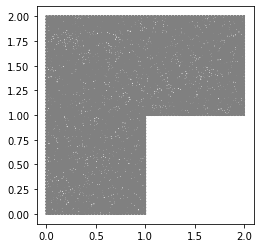

[  9.66563342  15.21383498  19.76809834  29.58517692  32.03443308
  41.63505059  45.09459346  49.52493965  49.52656789  56.98614177
  65.68976066  71.47048371  71.94828463  79.41695865  90.02334467
  92.92609258  98.06804218  99.39606182  99.41398408 102.42160044
 113.32366624 116.4818151  129.50051083 129.52354059 131.34287248
 131.51881578 144.04847069]


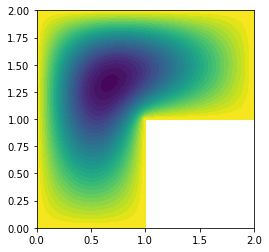

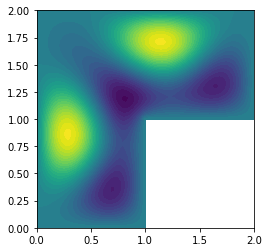

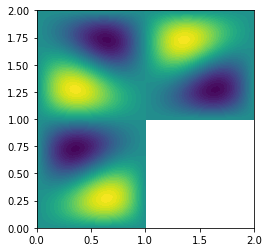

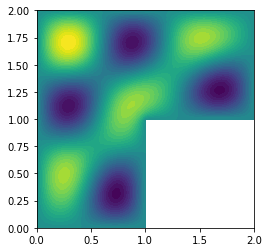

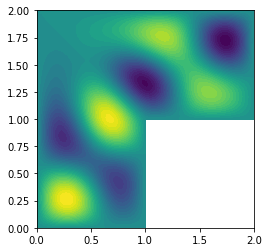

In [50]:
test_points = [ [0.,0.], [1.,0.], [1.,1.], [2.,1.,], [2.,2.], [0.,2.], [0.,0.]]

N = 60
lx = 0.2
ly = 0.1
lz = 1.0
testmesh = UnitSquareMesh(100,100)
testmesh = generate_mesh_from_coords(test_points, 50)
plot(testmesh)
plt.show()

eigenvals, v = eigenpair_solver(testmesh, 25)
print(eigenvals)

def select_plot(label):

  # get the index that corresponds to the word "label"
  index = labels.index(label)
  
  # set the plot to visible
  plots[index].set_visible(not plots[index].get_visible())
  fig.canvas.draw()
  
  plot_button.on_clicked(select_plot)
  plt.show()
  
plots = [0, 5, 8, 9, 10]

# for i in range(0, 25):
for i in plots:
    # print(i)
    # plt.subplot(5, 5, i+1)
    # plt.subplot(5,5)

    plot(v[i])
    plt.show()


# plt.show()

# Results
